# Comparación de Convex Hull Estático vs Dinámico
Este notebook contiene tres benchmarks:
- Eliminación de puntos
- Inserciones continuas con consultas
- Inserciones periódicas con consultas espaciadas

Se usa la implementación de envolvente convexa estática con Monotone Chain y dinámica con Bentley–Saxe.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from app.convex_hull import ConvexHull
from app.dynamic_convex_hull import DynamicConvexHull
from app.point import Point

In [9]:
def random_points(n):
    return [Point(float(x), float(y)) for x, y in zip(
        np.random.uniform(0, 1000, n),
        np.random.uniform(0, 1000, n)
    )]

def generate_points(n, max_coord=1000):
    return [Point(random.randint(0, max_coord), random.randint(0, max_coord)) for _ in range(n)]

In [10]:
def static_hull_delete_benchmark(points, points_to_delete):
    current_points = list(points)
    total_time = 0.0
    for pt in points_to_delete:
        current_points = [p for p in current_points if (p.x, p.y) != (pt.x, pt.y)]
        ch = ConvexHull()
        for p in current_points:
            ch.append_point(p.x, p.y)
        t0 = time.time()
        ch.get_hull()
        t1 = time.time()
        total_time += (t1 - t0)
    return total_time

def dynamic_hull_delete_benchmark(points, points_to_delete):
    dch = DynamicConvexHull()
    for p in points:
        dch.insert(p)
    t0 = time.time()
    for pt in points_to_delete:
        dch.delete(pt)
    t1 = time.time()
    return t1 - t0

N=1000 Eliminados=400: Estático=0.4371s | Dinámico=0.0032s
N=2000 Eliminados=800: Estático=1.8554s | Dinámico=0.0071s
N=3000 Eliminados=1200: Estático=4.0908s | Dinámico=0.0131s
N=4000 Eliminados=1600: Estático=7.7584s | Dinámico=0.0173s
N=5000 Eliminados=2000: Estático=12.2263s | Dinámico=0.0162s


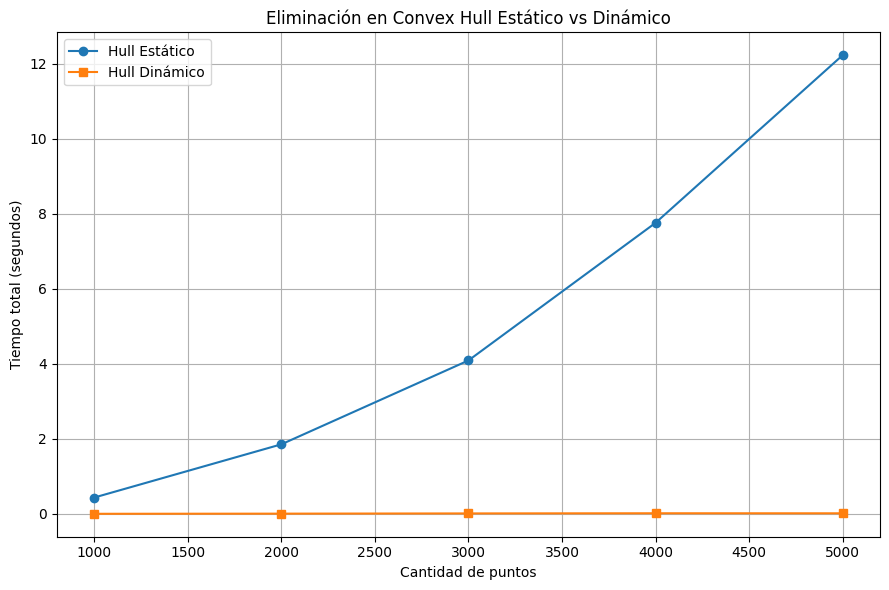

In [15]:
sizes = [1000, 2000, 3000, 4000, 5000]
percent_delete = 0.4
times_static = []
times_dynamic = []

for n in sizes:
    pts = random_points(n)
    idx_to_delete = np.random.choice(range(n), int(n * percent_delete), replace=False)
    pts_to_del = [pts[i] for i in idx_to_delete]

    t_static = static_hull_delete_benchmark(pts, pts_to_del)
    t_dynamic = dynamic_hull_delete_benchmark(pts, pts_to_del)

    times_static.append(t_static)
    times_dynamic.append(t_dynamic)

    print(f"N={n} Eliminados={len(pts_to_del)}: Estático={t_static:.4f}s | Dinámico={t_dynamic:.4f}s")

plt.figure(figsize=(9,6))
plt.plot(sizes, times_static, marker='o', label='Hull Estático')
plt.plot(sizes, times_dynamic, marker='s', label='Hull Dinámico')
plt.xlabel('Cantidad de puntos')
plt.ylabel('Tiempo total (segundos)')
plt.title('Eliminación en Convex Hull Estático vs Dinámico')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

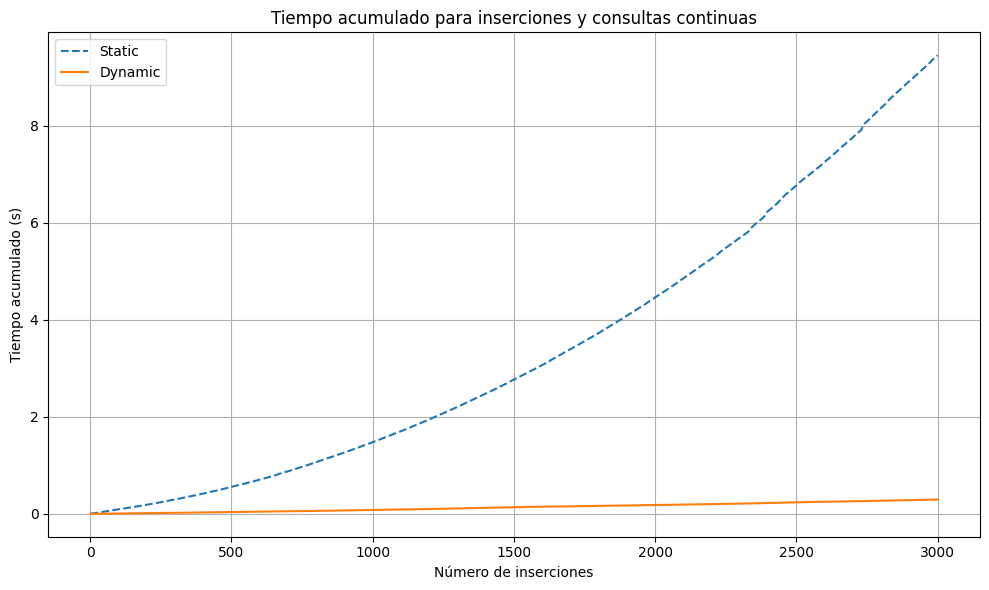

In [12]:
initial_n = 500
insertions_total = 3000
initial_points = generate_points(initial_n)
insertion_points = generate_points(insertions_total)

# Estático
static_hull = ConvexHull()
for p in initial_points:
    static_hull.append_point(p.x, p.y)
static_hull.calculate_monotone_chain()
static_query_times = []
start = time.time()
for p in insertion_points:
    static_hull.append_point(p.x, p.y)
    static_hull.get_hull()
    static_hull.is_inside_convex_hull(p)
    static_query_times.append(time.time() - start)

# Dinámico
dynamic_hull = DynamicConvexHull()
for p in initial_points:
    dynamic_hull.insert(p)
dynamic_query_times = []
start = time.time()
for p in insertion_points:
    dynamic_hull.insert(p)
    dynamic_hull.get_hull()
    dynamic_hull.is_inside(p)
    dynamic_query_times.append(time.time() - start)

# Gráfico
x_values = list(range(1, insertions_total + 1))
plt.figure(figsize=(10, 6))
plt.plot(x_values, static_query_times, label="Static", linestyle='--')
plt.plot(x_values, dynamic_query_times, label="Dynamic", linestyle='-')
plt.xlabel("Número de inserciones")
plt.ylabel("Tiempo acumulado (s)")
plt.title("Tiempo acumulado para inserciones y consultas continuas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

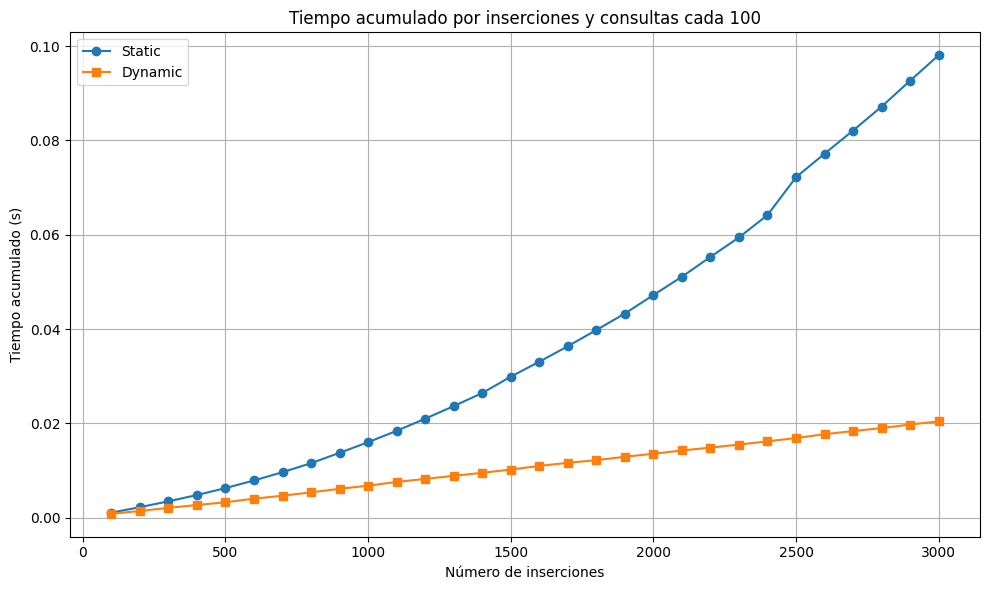

In [13]:
query_interval = 100
static_convex_hull = ConvexHull()
for p in initial_points:
    static_convex_hull.append_point(p.x, p.y)
static_convex_hull.get_hull()
static_times = []
start = time.time()
for i, p in enumerate(insertion_points, 1):
    static_convex_hull.append_point(p.x, p.y)
    if i % query_interval == 0:
        static_convex_hull.get_hull()
        static_times.append(time.time() - start)

dynamic_convex_hull = DynamicConvexHull()
for p in initial_points:
    dynamic_convex_hull.insert(p)
dynamic_times = []
start = time.time()
for i, p in enumerate(insertion_points, 1):
    dynamic_convex_hull.insert(p)
    if i % query_interval == 0:
        dynamic_convex_hull.get_hull()
        dynamic_times.append(time.time() - start)

x_values = list(range(query_interval, insertions_total + 1, query_interval))
plt.figure(figsize=(10, 6))
plt.plot(x_values, static_times, marker='o', label='Static')
plt.plot(x_values, dynamic_times, marker='s', label='Dynamic')
plt.xlabel("Número de inserciones")
plt.ylabel("Tiempo acumulado (s)")
plt.title("Tiempo acumulado por inserciones y consultas cada 100")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
import cProfile
import pstats
import random
import os
from typing import List, Tuple
from app.convex_hull import ConvexHull
from app.dynamic_convex_hull import DynamicConvexHull
from app.point import Point

N_INSERTIONS = 2000
N_QUERIES = 200
SEED = 42
OUTPUT_STATIC = "data/profile_static.csv"
OUTPUT_DYNAMIC = "data/profile_dynamic.csv"
os.makedirs("data", exist_ok=True)

def generate_points(n, max_coord=1000):
    return [Point(random.randint(0, max_coord), random.randint(0, max_coord)) for _ in range(n)]

def write_header(f):
    f.write('structure,phase,method_name,total_time,cumulative_time,per_call_time\n')

def write_row(f, structure, phase, method_name, total_time, cumulative_time, per_call_time):
    f.write(f'{structure},{phase},{method_name},{total_time:.6f},{cumulative_time:.6f},{per_call_time:.6f}\n')

def get_method_stats(stats: pstats.Stats, target_keywords: List[str]):
    ps = stats.strip_dirs().stats
    def matches(key):
        return any(kw in key[2] for kw in target_keywords)
    result = []
    for key in filter(matches, ps.keys()):
        method_name = key[2]
        cc, nc, tt, ct, _ = ps[key]
        per_call = ct / nc if nc > 0 else 0
        result.append((method_name, tt, ct, per_call))
    return result

# ------------------------
# STATIC PROFILING
# ------------------------
random.seed(SEED)
points = generate_points(N_INSERTIONS)
queries = generate_points(N_QUERIES)

with open(OUTPUT_STATIC, "w") as f:
    write_header(f)
    ch = ConvexHull()

    profiler_insert = cProfile.Profile()
    profiler_insert.enable()
    for p in points:
        ch.append_point(p.x, p.y)
        ch.get_hull()
    profiler_insert.disable()

    stats_insert = pstats.Stats(profiler_insert)
    for method, tt, ct, pc in get_method_stats(stats_insert, ["append_point", "get_hull"]):
        write_row(f, "static", "insertions_with_recalculation", method, tt, ct, pc)

    profiler_query = cProfile.Profile()
    profiler_query.enable()
    for q in queries:
        ch.is_inside_convex_hull(q)
    profiler_query.disable()

    stats_query = pstats.Stats(profiler_query)
    for method, tt, ct, pc in get_method_stats(stats_query, ["is_inside_convex_hull"]):
        write_row(f, "static", "query_only", method, tt, ct, pc)

# ------------------------
# DYNAMIC PROFILING
# ------------------------
random.seed(SEED)
points = generate_points(N_INSERTIONS)
queries = generate_points(N_QUERIES)

with open(OUTPUT_DYNAMIC, "w") as f:
    write_header(f)
    dch = DynamicConvexHull()

    profiler_insert = cProfile.Profile()
    profiler_insert.enable()
    for p in points:
        dch.insert(p)
        dch.get_hull()
    profiler_insert.disable()

    stats_insert = pstats.Stats(profiler_insert)
    for method, tt, ct, pc in get_method_stats(stats_insert, ["insert", "get_combined_hull"]):
        write_row(f, "dynamic", "insertions_with_recalculation", method, tt, ct, pc)

    profiler_query = cProfile.Profile()
    profiler_query.enable()
    for q in queries:
        dch.is_inside(q)
    profiler_query.disable()

    stats_query = pstats.Stats(profiler_query)
    for method, tt, ct, pc in get_method_stats(stats_query, ["is_inside_convex_hull"]):
        write_row(f, "dynamic", "query_only", method, tt, ct, pc)